# Import

In [3]:
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from bioreactor.plotting import *
from bioreactor.utils import *
from bioreactor.ssgsea import *
from bioreactor.gsea import *
from bioreactor.annotation import *
from bioreactor.survival import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('ticks')


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

# Data

In [4]:
df_raw = read_dataset('data/raw/Epic_Supra_V_1_mod_2.csv')
df_dates  = pd.read_excel('data/raw/Epic_Supra_dates_v2.xlsx', index_col=0)

In [5]:
renamer = read_dataset('data/raw/Column_Renamer.tsv')

In [6]:
df = {}
for col in df_dates:
    df[col] = df_dates[col]
for col in df_raw:
    if col not in df.keys():
        df[col] = df_raw[col].reindex(df_dates.index)
df = pd.DataFrame(df)

In [7]:
df.columns = df.columns.map(lambda x: renamer.loc[x,'English_Column_Name_Short'])
df

,Birth_Date,OS_Date,OS_Date_unknown,OS_Date_only_year,Last_FU,Last_FU_only_year,Sx_Date,REOP_DAT,FUEcho_Date,Age,...,FUEcho_LVOT,FUEcho_PAP,FUEcho_IVSd,FUEcho_MPG,FUEcho_Vmax,FUEcho_AOF,FUEcho_Signs_of_SVD,FUEcho_SVD_VARC3,FUEcho_AI,FUEcho_PHT
Item,,,,,,,,,,,,,,,,,,,,,
10,1959-01-13,NaT,NaN,NaN,2020-12-03 08:32:17,NaN,2016-05-02,NaT,2020-12-03,57,...,2.4,NaN,1.20,7.0,2.00,1.86,0.0,0.00,0.0,NaN
263,1938-08-15,NaT,NaN,NaN,NaT,NaN,2011-02-03,NaT,NaT,72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,1940-03-05,2011-11-13,NaN,NaN,2011-11-01 00:00:00,NaN,2011-02-08,2011-02-10,2011-11-01,70,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
267,1935-05-24,NaT,NaN,NaN,2011-11-01 00:00:00,NaN,2011-02-10,NaT,2020-08-14,75,...,NaN,50.0,1.30,NaN,2.46,NaN,0.0,NaN,1.0,1.0
268,1928-05-18,NaT,NaN,NaN,2021-07-30 00:00:00,NaN,2011-02-14,2011-02-23,2021-07-01,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,1963-05-23,2021-08-27,NaN,NaN,2021-08-27 00:00:00,NaN,2021-08-26,NaT,NaT,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2078,1945-03-07,NaT,NaN,NaN,NaT,NaN,2021-11-09,NaT,NaT,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2079,1955-10-12,NaT,NaN,NaN,NaT,NaN,2021-11-10,NaT,NaT,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
reop_cols = [i for i in df.columns if 'REOP' in i]
reop_cols

['REOP_DAT',
 'REOP?',
 'REOP_RELA',
 'REOP_THGNR',
 'REOP_EINGR',
 'REOP_DAT2',
 'REOP_THG2',
 'REOP_EING2',
 'REOP_DAT3',
 'REOP_THG3',
 'REOP_EING3',
 'REOP_DAT4',
 'REOP_THG4',
 'REOP_EING4',
 'REOP_DAT5',
 'REOP_THG5',
 'REOP_EING5']

In [13]:
from datetime import datetime

for reop_col in [i for i in df.columns if 'REOP_DAT' in i and i!='REOP_DAT']:
    df[reop_col] = pd.to_datetime(df[reop_col], format='%m/%d/%Y')

In [14]:
suitable_timing_reop = {reop_col:{} for reop_col in [i for i in df.columns if 'REOP_DAT' in i]}
from datetime import timedelta

for i in df[~df.Sx_Date.isna()].index:
    sx_date = df.loc[i, 'Sx_Date']
    for reop_col in suitable_timing_reop.keys():
        reop_date = df.loc[i, reop_col]
        if issubclass(type(reop_date), type(pd.NaT)):
            suitable_timing_reop[reop_col][i] = np.nan
        else:
            if (reop_date-sx_date)<=timedelta(days=30):
                suitable_timing_reop[reop_col][i] = True
            else:
                suitable_timing_reop[reop_col][i] = False
suitable_timing_reop = pd.DataFrame(suitable_timing_reop)
suitable_timing_reop

,REOP_DAT,REOP_DAT2,REOP_DAT3,REOP_DAT4,REOP_DAT5
10,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,NaN,NaN,NaN
265,True,False,False,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN
268,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2077,NaN,NaN,NaN,NaN,NaN
2078,NaN,NaN,NaN,NaN,NaN
2079,NaN,NaN,NaN,NaN,NaN
2080,NaN,NaN,NaN,NaN,NaN


In [15]:
suitable_timing_reop[suitable_timing_reop == True].fillna(0).astype(int).sum()

REOP_DAT     243
REOP_DAT2     64
REOP_DAT3     16
REOP_DAT4      6
REOP_DAT5      1
dtype: int64

In [16]:
reop_tr = pd.read_csv('data/raw/REOP_EINGR_translation.tsv',sep='\t')
reop_tr['german'] = reop_tr['Немецкий термин'].str.lower().str.replace(' ','')
reop_tr['implant_used'] = reop_tr['Использование имплантанта']=='Да'
reop_tr.head()

,Немецкий термин,Русский перевод,Использование имплантанта,german,implant_used
0,Aortenklappe Xenotransplantat: mediane Sternot...,Ксенотрансплантация аортального клапана: среди...,Да,aortenklappexenotransplantat:medianesternotomie,True
1,Aortenklappe: Endovaskuläre Implantation ohne HLM,Аортальный клапан: эндоваскулярная имплантация...,Да,aortenklappe:endovaskuläreimplantationohnehlm,True
2,Bypass 1-fach mit Aorten- und Mitralklappeners...,Одиночное шунтирование с заменой аортального и...,Да,bypass1-fachmitaorten-undmitralklappenersatzmi...,True
3,Bypass 1-fach mit Aortenklappenersatz mit HLM ...,Шунтирование 1-кратное с заменой аортального к...,Да,bypass1-fachmitaortenklappenersatzmithlmundmed...,True
4,Bypass 1-fach mit Aortenklappenersatz und Mitr...,Шунтирование 1-кратное с заменой аортального к...,Да,bypass1-fachmitaortenklappenersatzundmitralkla...,True


In [17]:
suitable_reop_types = {reop_col:{} for reop_col in [i for i in df.columns if 'REOP_EING' in i]}
for i in df.index:
    for reop_col in suitable_reop_types.keys():
        reop_type = df.loc[i, reop_col]
        if type(reop_type)==str:
            implant_used = reop_tr[reop_tr.german==reop_type.lower().replace(' ', '')].implant_used
            suitable_reop_types[reop_col][i]=implant_used.values[0]
        else:
            suitable_reop_types[reop_col][i]=np.nan
suitable_reop_types = pd.DataFrame(suitable_reop_types)
suitable_reop_types

,REOP_EINGR,REOP_EING2,REOP_EING3,REOP_EING4,REOP_EING5
10,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,NaN,NaN,NaN
265,False,False,False,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN
268,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2077,NaN,NaN,NaN,NaN,NaN
2078,NaN,NaN,NaN,NaN,NaN
2079,NaN,NaN,NaN,NaN,NaN
2080,NaN,NaN,NaN,NaN,NaN


In [18]:
suitable_reop_types[suitable_reop_types == True].fillna(0).astype(int).sum()

REOP_EINGR    121
REOP_EING2     25
REOP_EING3      6
REOP_EING4      2
REOP_EING5      1
dtype: int64

In [19]:
suitable_types = suitable_reop_types[suitable_reop_types == True].fillna(0).astype(int)
suitable_types.columns = [1,2,3,4,5]
suitable_times = suitable_timing_reop[suitable_timing_reop == True].fillna(0).astype(int)
suitable_times.columns = [1,2,3,4,5]

In [20]:
suitable_times.T.sum().value_counts()

0    1553
1     178
2      49
3      11
4       4
5       1
Name: count, dtype: int64

In [21]:
implantated_reop_pats = {i:0 for i in suitable_times.index}

for col in suitable_times.columns:
    for i in suitable_times.index:
        if suitable_times.loc[i,col]==1 and suitable_types.loc[i,col]==1:
            implantated_reop_pats[i] += 1
implantated_reop_pats = pd.Series(implantated_reop_pats)
implantated_reop_pats.sort_values()

10      0
1469    0
1468    0
1467    0
1466    0
       ..
398     2
1244    2
876     2
1738    2
622     2
Length: 1796, dtype: int64

<Axes: ylabel='Density'>

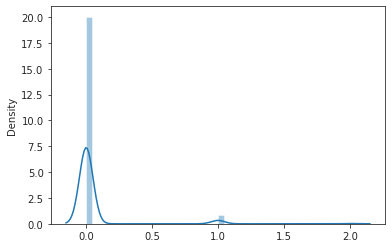

In [56]:
sns.distplot(implantated_reop_pats)

In [22]:
df_en = read_dataset('df_en.csv',sep=',')
df_en

,Birth_Date,Age,OS_Event,OS_Date,Mortality_Days,Last_FU,Gender,Height,Weight,BMI,...,FUEcho_PAP,FUEcho_IVSd,FUEcho_MPG,FUEcho_Vmax,FUEcho_AOF,FUEcho_Signs_of_SVD,FUEcho_SVD_VARC3,FUEcho_AI,FUEcho_PHT,FUEcho_Date
Case_Num,,,,,,,,,,,,,,,,,,,,,
10,1959-01-13,57,0,NaN,NaN,2020-12-03 08:32:17,M,176,104,33.574380,...,NaN,1.2,7.0,2.00,1.86,0.0,0.0,0.0,NaN,2020-12-03
263,1938-08-15,72,0,NaN,NaN,NaN,W,153,80,34.174889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,1940-03-05,70,1,2011-11-13 00:00:00,278.0,2011-11-01 00:00:00,W,163,52,19.571681,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2011-11-01
267,1935-05-24,75,0,NaN,NaN,2011-11-01 00:00:00,M,170,85,29.411764,...,50.0,1.3,NaN,2.46,NaN,0.0,NaN,1.0,1.0,2020-08-14
268,1928-05-18,82,0,NaN,NaN,2021-07-30 00:00:00,W,153,50,21.359306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2021-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,1963-05-23,58,1,2021-08-27 00:00:00,1.0,2021-08-27 00:00:00,M,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2078,1945-03-07,76,0,NaN,NaN,NaN,M,163,79,29.733900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2079,1955-10-12,66,0,NaN,NaN,NaN,M,175,80,26.122448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
pd.crosstab(df_en['REOP?'].fillna('na'), suitable_times.T.sum().fillna('na'))

col_0,0,1,2,3,4,5
REOP?,,,,,,
0,1455,0,0,0,0,0
1,98,178,49,11,4,1


In [24]:
df_en['Reop_num_within_30_with_implant'] = implantated_reop_pats.reindex(df_en.index)
df_en['Reop_num_within_30'] = suitable_times.T.sum().reindex(df_en.index)

In [25]:
safety_cols = ['FUEcho_Signs_of_SVD','Reop_num_within_30_with_implant','Reop_num_within_30', 'REOP?']+[i for i in df_en.columns if 'LQ_' in i and i != 'LQ_LQ']
safety_cols

['FUEcho_Signs_of_SVD',
 'Reop_num_within_30_with_implant',
 'Reop_num_within_30',
 'REOP?',
 'LQ_Mobility',
 'LQ_Self_Care',
 'LQ_Dayt_Activity',
 'LQ_Pain',
 'LQ_Fear']

In [26]:
df_en = df_en[~df_en.Upsizing.isna()]
df_en.shape

(1529, 112)

In [29]:
implanted_earlier = {i:0 for i in df_en.index}
impl_cols = ['Implanted_Pacemaker','Implanted_Defibrillator','Implanted_Card_Resynch_Therapy']
for i in df_en.index:
    for col in impl_cols:
        if df_en.loc[i, col] == 1:
            implanted_earlier[i] +=1
implanted_earlier = pd.Series(implanted_earlier)[df_en[impl_cols].dropna(how='all').index]
print(implanted_earlier.value_counts())
df_en['Implanted_Earlier'] = implanted_earlier.reindex(df_en.index)
df_en['Implanted_Earlier'] = pd.cut(df_en['Implanted_Earlier'], [-np.inf, 0, np.inf], labels=[0,1])
df_en['log10_STS'] = np.log10(df_en.STS+1)

0    1378
1      85
2       6
Name: count, dtype: int64


In [31]:
base_formula = 'Age + BMI + Gender + log10_STS + NYHA_Heart_Fail_Class + Prosthesis_Anat_Aort_Valve + Prosthesis_Anat_Size'
base_cols = base_formula.split(' + ')

In [33]:
surg_vars = '+ Sx_Aort_Clamp_t + Sx_Date'
add_vars = '+ Implanted_Earlier'

df_add_vars = df_en[base_cols+['Upsizing','Sx_Aort_Clamp_t','Sx_Date','Implanted_Earlier']].dropna()
df_add_vars.shape

(1469, 11)

In [34]:
df_full_safety = df_en[base_cols+['Upsizing','Sx_Aort_Clamp_t','Sx_Date','Implanted_Earlier']+safety_cols].dropna()
df_full_safety.shape

(420, 20)

In [35]:
df_reop_safety = df_en[base_cols+['Upsizing','Sx_Aort_Clamp_t','Sx_Date','Implanted_Earlier']+['Reop_num_within_30_with_implant',
 'Reop_num_within_30',
 'REOP?']].dropna()
df_reop_safety.shape

(1469, 14)

In [36]:
df_svd_safety = df_en[base_cols+['Upsizing','Sx_Aort_Clamp_t','Sx_Date','Implanted_Earlier']+['FUEcho_Signs_of_SVD']].dropna()
df_svd_safety.shape

(590, 12)

In [37]:
df_lq_safety = df_en[base_cols+['Upsizing','Sx_Aort_Clamp_t','Sx_Date','Implanted_Earlier']+['LQ_Mobility',
 'LQ_Self_Care',
 'LQ_Dayt_Activity',
 'LQ_Pain',
 'LQ_Fear']].dropna()
df_lq_safety.shape
#все в районе 660

(652, 16)

In [38]:
df_reop_safety['REOP_Flag'] = df_reop_safety['REOP?']
df_reop_safety['Reop_num_within_30_with_implant_Flag'] = pd.Series(index = pd.cut(df_reop_safety['Reop_num_within_30_with_implant'], bins=[-np.inf,0,np.inf], labels=[0,1]).index, data = pd.cut(df_reop_safety['Reop_num_within_30_with_implant'], bins=[-np.inf,0,np.inf], labels=[0,1]).values.to_list())
df_reop_safety['Reop_num_within_30_Flag'] = pd.Series(index=pd.cut(df_reop_safety['Reop_num_within_30'], bins=[-np.inf,0,np.inf], labels=[0,1]).index, data = pd.cut(df_reop_safety['Reop_num_within_30'], bins=[-np.inf,0,np.inf], labels=[0,1]).values.to_list())

data = df_reop_safety
cols = ['Reop_num_within_30_with_implant_Flag',
 'Reop_num_within_30_with_implant_Flag',
 'REOP_Flag']

formula = base_formula

In [74]:
df_en['Sx_Surgeon_shortened'] = df.Sx_Surgeon
df_en.loc[df_en[df_en.Sx_Surgeon.isin(df_en.Sx_Surgeon.value_counts()[df_en.Sx_Surgeon.value_counts()<100].index)].index, 'Sx_Surgeon_shortened'] = 'Other, less than 100 ops'

df_en.Sx_Surgeon_shortened.value_counts()

Sx_Surgeon_shortened
Prof. Dr. med. T. Doenst      348
Other, less than 100 ops      333
OA Dr. med. M. Diab           272
PD Dr. med. M. Richter        260
Ltd. OÄ Dr. med. G. Färber    163
OA Dr. med. T. Sandhaus       152
Name: count, dtype: int64

In [80]:
df_en['Sx_Urgency_shortened'] = df_en.Sx_Urgency
df_en['Sx_Urgency_shortened'].loc[df_en.Sx_Urgency_shortened==4] = 3

In [81]:

columns = ['Age', 'BMI', 'Gender', 'log10_STS', 'NYHA_Heart_Fail_Class', 'Prosthesis_Anat_Aort_Valve', 'Sx_Cardiopulm_Bypass_t','Sx_Intraop_Stimul','Prosthesis_Anat_Size', 'Upsizing', 'Sx_Aort_Clamp_t', 'Sx_Date', 'Implanted_Earlier','Sx_Duration_Min', 'Reop_num_within_30_with_implant', 'Reop_num_within_30', 'REOP?', 'LQ_Mobility', 'LQ_Self_Care', 'LQ_Dayt_Activity', 'LQ_Pain', 'LQ_Fear', 'Endocard','Sx_Surgeon_shortened', 'Sx_Urgency_shortened']

# Отбор нужных столбцов из df_en
df_en_selected = df_en[columns]

for i in df_reop_safety.columns:
    if i not in df_en_selected.columns:
        df_en_selected[i] = df_reop_safety[i]
for i in df_svd_safety.columns:
    if i not in df_en_selected.columns:
        df_en_selected[i] = df_svd_safety[i]

In [82]:
df_en_selected.Sx_Urgency_shortened.value_counts()

Sx_Urgency_shortened
1    1094
2     334
3     101
Name: count, dtype: int64

In [83]:
df_en_selected.to_csv('df_safety_surg_lq.tsv',sep='\t')